In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
X = df.iloc[:, 2:].sum()
rowsums = df.iloc[:, 2:].sum(axis = 1)

non_lab = 0

for i, count in rowsums.items():
    if count == 0:
        non_lab += 1

print(f"Кількість коментарів = {len(df)}")
print(f"Кількість нормальних = {non_lab}")
print(f"Кількість негативних коментарів = {X.sum()}")

Кількість коментарів = 159571
Кількість нормальних = 143346
Кількість негативних коментарів = 35098


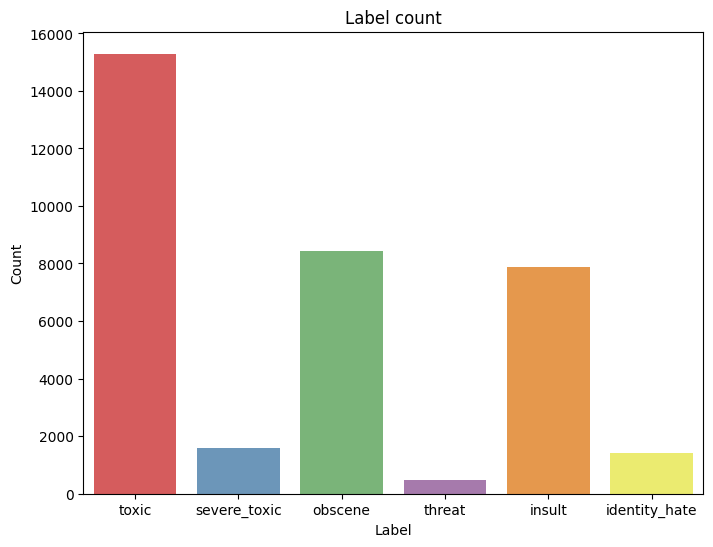

In [7]:
plt.figure(figsize = (8, 6))
ax = sns.barplot(x = X.index, y = X.values, alpha = 0.8, palette = 'Set1')
plt.title('Label count')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

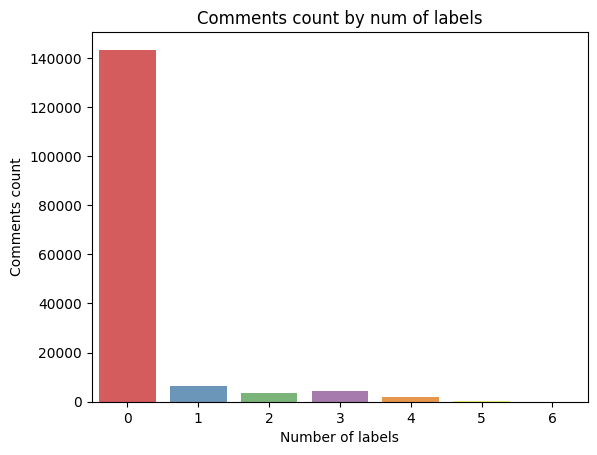

In [8]:
sns.countplot(x = rowsums.values, palette = 'Set1', alpha = 0.8)
plt.title('Comments count by num of labels')
plt.xlabel('Number of labels')
plt.ylabel('Comments count')
plt.show()

In [9]:
df.iloc[:,2:].sum(axis = 1).value_counts()

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: count, dtype: int64

In [10]:
df.drop('id', axis = 1, inplace = True)

In [11]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [12]:
stopwords = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stopwords]
    return " ".join(no_stopword_text)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

# stemming
stemmer = SnowballStemmer('english')
def stemming(sentence):
    stemmed_sentence = ""
    for word in sentence.split():
        stemmed_word = stemmer.stem(word)
        stemmed_sentence += stemmed_word + " "
        
    stemmed_sentence = stemmed_sentence.strip()
    return stemmed_sentence

In [13]:
df['comment_text'] = df['comment_text'].apply(lambda x: remove_stopwords(x))
df['comment_text'] = df['comment_text'].apply(lambda x: clean_text(x))
df['comment_text'] = df['comment_text'].apply(lambda x: stemming(x))
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explan whi edit made usernam hardcor metallica...,0,0,0,0,0,0
1,d aww he match background colour i am seem stu...,0,0,0,0,0,0
2,hey man i am realli tri edit war it guy consta...,0,0,0,0,0,0
3,more i can not make real suggest improv i wond...,0,0,0,0,0,0
4,you sir hero ani chanc rememb page that on,0,0,0,0,0,0


In [14]:
X = df['comment_text']
y = df.drop('comment_text', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [15]:
def run_pipeline(pipeline, X_train, X_test, y_train, y_test):

    pipeline.fit(X_train, y_train)
    
    predictions = pipeline.predict(X_test)
    pred_probs = pipeline.predict_proba(X_test)
    
    print('roc_auc:', roc_auc_score(y_test, pred_probs))
    print('accuracy:', accuracy_score(y_test, predictions))
    print('classification report')
    print(classification_report(y_test, predictions, target_names=y_train.columns))

In [16]:
NB_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb_model', OneVsRestClassifier(MultinomialNB(), n_jobs=-1))
])

LR_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb_model', OneVsRestClassifier(LogisticRegression(), n_jobs=-1))
])

In [17]:
run_pipeline(NB_pipeline, X_train, X_test, y_train, y_test)

roc_auc: 0.8645683817398219
accuracy: 0.8980416731944227
classification report
               precision    recall  f1-score   support

        toxic       0.99      0.19      0.32      3101
 severe_toxic       0.00      0.00      0.00       329
      obscene       0.98      0.12      0.21      1698
       threat       1.00      0.01      0.02        91
       insult       0.91      0.05      0.09      1594
identity_hate       0.00      0.00      0.00       298

    micro avg       0.98      0.12      0.22      7111
    macro avg       0.65      0.06      0.11      7111
 weighted avg       0.88      0.12      0.21      7111
  samples avg       0.02      0.01      0.01      7111



In [18]:
run_pipeline(LR_pipeline, X_train, X_test, y_train, y_test)

roc_auc: 0.9780751868089371
accuracy: 0.917123609587968
classification report
               precision    recall  f1-score   support

        toxic       0.90      0.62      0.73      3101
 severe_toxic       0.57      0.23      0.33       329
      obscene       0.90      0.65      0.76      1698
       threat       0.44      0.08      0.13        91
       insult       0.80      0.52      0.63      1594
identity_hate       0.63      0.22      0.32       298

    micro avg       0.86      0.56      0.68      7111
    macro avg       0.71      0.39      0.48      7111
 weighted avg       0.85      0.56      0.67      7111
  samples avg       0.06      0.05      0.05      7111



In [19]:
labels = y_train.columns.values


In [20]:
X_test.sample(1).values[0]

'the navig templat goe articl where heck wantit go bottom page not standard format work me now'

In [21]:
sentence = "hello i am totally fine"
stemmed_sentence = stemming(sentence)
results = LR_pipeline.predict([stemmed_sentence])[0]
for label, result in zip(labels, results):
    print("%14s %5s" % (label, result))

         toxic     0
  severe_toxic     0
       obscene     0
        threat     0
        insult     0
 identity_hate     0


In [22]:
sentence = "I will put a paper bag over head head and fuck him in the ass in front of his family and give him to the Jews for auction."
stemmed_sentence = stemming(sentence)
results = LR_pipeline.predict([stemmed_sentence])[0]
for label, result in zip(labels, results):
    print("%14s %5s" % (label, result))

         toxic     1
  severe_toxic     0
       obscene     1
        threat     0
        insult     1
 identity_hate     0


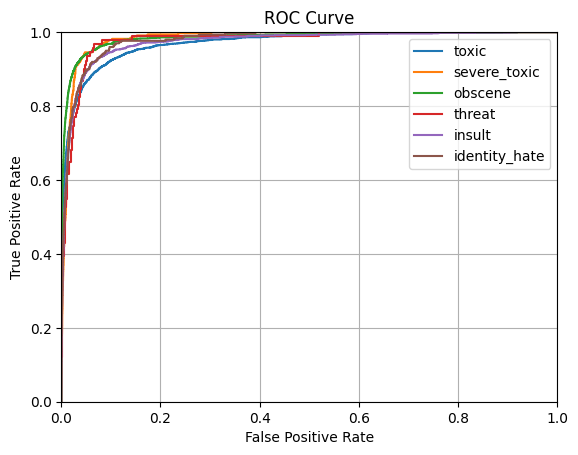

In [23]:
def plot_roc_curve(test_labels, predict_prob):
    fpr, tpr, thresholds = roc_curve(test_labels, predict_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend(labels)
    
def plot_pipeline_roc_curve(pipeline, X_train, X_test, y_train, y_test):
    for label in labels:
        pipeline.fit(X_train, y_train[label])
        pred_probs = pipeline.predict_proba(X_test)[:, 1]
        plot_roc_curve(y_test[label], pred_probs)

plot_pipeline_roc_curve(LR_pipeline, X_train, X_test, y_train, y_test)